# Import packages

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), "../.."))

import random
import numpy as np

import torch
from torch import distributions
from torch import nn
from torch.utils import data

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import scipy.optimize as sci_op

%reload_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

import project
import project.networks.net as net
from project.models.triple_well   import TripleWell

os.environ['KMP_DUPLICATE_LIB_OK']='True'

UsageError: unrecognized arguments: # Reload all modules every time before executing the Python code typed.


In [3]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

# Visualize triple well potential
Energy landscape for triple well E is the potential used for the hyperparameter optimization. The function is an adjusted version of the triple well potential as described in ref[1], which was originally described in ref[2]. Due to a faulty implementation of the function (E1 was the original function used and E2 is the function as decribed in ref[1]) the potential had a large valley in the area to the left of the y axis and underneath the x-axis. We noticed this after initial training (before the hyperparameter optimization) and therefore deepened the potential by multiplying the whole function by a factor 3, raising the entire function by adding a scalar of 5 to the resulting function and subsequently adding a harmonic potential with a standard deviation of 0.1 such that the deep unwanted well was formed into a peak. This formed an asymmetric 2 dimensional function with three wells of depth


@article{hoffmann2021deeptime,
  title={Deeptime: a Python library for machine learning dynamical models from time series data},
  author={Hoffmann, Moritz and Scherer, Martin Konrad and Hempel, Tim and Mardt, Andreas and de Silva, Brian and Husic, Brooke Elena and Klus, Stefan and Wu, Hao and Kutz, J Nathan and Brunton, Steven and Noé, Frank},
  journal={Machine Learning: Science and Technology},
  year={2021},
  publisher={IOP Publishing}
}
2.
Christof Schütte and Marco Sarich. Metastability and Markov State Models in Molecular Dynamics. Volume 24. American Mathematical Soc., 2013.

Handy for more artificial energy landscapes.
http://www.sfu.ca/~ssurjano/optimization.html
https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=787014841

In [4]:
def E(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

In [5]:
def E1(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)

In [6]:
def E2(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( - x**2 - (y - (1/3))**2) - \
                3 * np.exp( - x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*(x**4) + 0.2*(y - (1/3))**4

In [26]:
def func_to_min(v): # default parameter values given in pg. 4 of the SI 
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,T=4.0,minimizer_kwargs={"method":"Powell"},stepsize=0.5,target_accept_rate=0.5,callback=callback)

CALLBACK [ 1.10631069 -0.0644589 ] -7.079108480168481 True
CALLBACK [ 1.1063107 -0.0644589] -7.07910848016848 True
CALLBACK [-1.14368984 -0.06104226] -8.429077669271972 True
CALLBACK [-1.1436901  -0.06104224] -8.429077669270963 True
CALLBACK [-1.14369005 -0.06104224] -8.429077669271372 True
CALLBACK [-1.14368985 -0.06104227] -8.429077669271974 True
CALLBACK [-1.14370802 -0.06104069] -8.429077663997951 True
CALLBACK [-1.14371264 -0.06104029] -8.42907766097836 True
CALLBACK [-1.14368985 -0.06104223] -8.429077669271964 True
CALLBACK [-1.14368985 -0.06104227] -8.429077669271972 True
CALLBACK [-1.14369881 -0.06104149] -8.429077667990361 True
CALLBACK [-1.14369834 -0.06104153] -8.429077668121387 True
CALLBACK [-1.14368984 -0.06104225] -8.429077669271972 True
CALLBACK [-1.14369004 -0.06104224] -8.429077669271397 True
CALLBACK [-1.14368993 -0.06104225] -8.429077669271884 True
CALLBACK [-1.14368986 -0.06104226] -8.429077669271974 True
CALLBACK [-1.14368983 -0.06104215] -8.429077669271807 True
C

In [29]:
def func_to_min(v): # default parameter values given in pg. 4 of the SI 
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,T=4.0,minimizer_kwargs={"method":"Powell"},stepsize=2,target_accept_rate=0.5,callback=callback)

CALLBACK [ 1.10631069 -0.0644589 ] -7.079108480168481 True
CALLBACK [-1.14368985 -0.06104226] -8.429077669271976 True
CALLBACK [-2.99931658 -2.99897464] 3.1925585535006147 False
CALLBACK [ 1.10631069 -0.06445889] -7.079108480168476 True
CALLBACK [-0.04214816  1.7083558 ] -1.9249774396889707 False
CALLBACK [ 1.10623905 -0.06446584] -7.079108397529869 True
CALLBACK [-1.14368979 -0.06104147] -8.429077669263906 True
CALLBACK [-1.14369011 -0.06104224] -8.429077669270926 True
CALLBACK [-1.14368858 -0.06104237] -8.429077669246329 True
CALLBACK [-1.14368922 -0.06104231] -8.429077669265599 True
CALLBACK [-1.14368985 -0.06104226] -8.429077669271976 True
CALLBACK [-1.14368986 -0.06104226] -8.429077669271974 True
CALLBACK [-2.99931652 -2.99897461] 3.192558553500615 False
CALLBACK [-0.04214816  1.7083558 ] -1.9249774396889714 False
CALLBACK [ 1.10631069 -0.06445891] -7.07910848016848 True
CALLBACK [-1.14368937 -0.06103777] -8.429077669006542 True
CALLBACK [-0.04214517  1.70834528] -1.92497743851640

In [17]:
print(minima_E)

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -8.429077669271976
                          x: [-1.144e+00 -6.104e-02]
                        nit: 1000
      minimization_failures: 0
                       nfev: 24666
                       njev: 8222
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: -8.429077669271976
                                    x: [-1.144e+00 -6.104e-02]
                                  nit: 5
                                  jac: [ 3.576e-07  4.768e-07]
                             hess_inv: [[ 3.133e-02 -2.657e-03]
                                        [-2.657e-03  3.956e-02]]
                                 nfev: 24
                                 njev: 8


In [7]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E2(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x1",
    yaxis_title="x2",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

In [ ]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E2(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x1",
    yaxis_title="x2",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

We can plot this energy landscape as is done in Fig. 2 of Noe et al: 

In [7]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x1",
    yaxis_title="x2",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

For the report, matplotlib works better for visualization: 

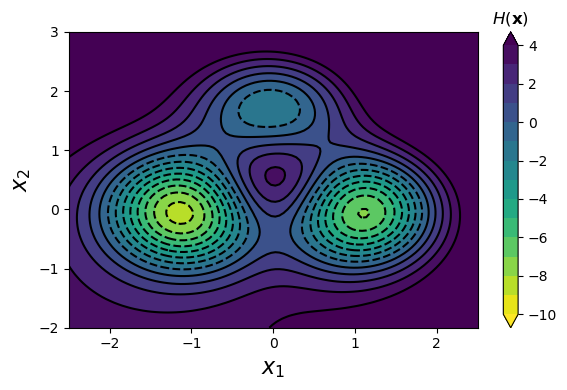

In [8]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',colors='k');
plt.contourf(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

This looks slightly different, specifically the minimum seem to be located at different positions from that in the paper. Let's plot $E=f(x)$:

In [9]:
fig = go.Figure(data=go.Scatter(x=x_illustrate, y=E(x_illustrate,0)))
fig.update_layout(
    xaxis_title="x",
    yaxis_title="E",
)
fig.show()

In [10]:
fig = go.Figure(data=go.Scatter(x=y_illustrate, y=E(0,y_illustrate)))
fig.update_layout(
    xaxis_title="x",
    yaxis_title="E",
)
fig.show()

# Generate sample configurations
Let's now generate sample configurations we will use as our input data set. These are meant to represent for example the results of molecular dynamics simulations. 

In [11]:
x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 500).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 500).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

# fig.update_xaxes(range=[-3,3])
# fig.update_yaxes(range=[-7,7])

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
#fig.write_image("images/double_well_with_points.pdf")

This is perhaps fine, but really what we should be doining is generating them via Metropolis Monte Carlo as is done in the Noe et al. (2019) paper: 

In [12]:
# Metropolis Monte Carlo for training set generation
sigma = 0.1
training_set_state_a = np.zeros((500,2))
training_set_state_a = np.zeros((500,2))

for i in range(training_set_state_a.shape[0]):
    pass
    # create configuration here

In [13]:
# x_state_a, y_state_a = np.random.multivariate_normal([-1.8,0], [[0.05, 0],[0,1]], 900).T
# x_state_b, y_state_b = np.random.multivariate_normal([1.8,0], [[0.05, 0],[0,1]], 100).T

x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 600).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 400).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=600,
    xaxis_title="$x_1$",
    yaxis_title="$x_2$",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()

Overlaying their energies on an energy vs. $x$ plot (with the blue line representing the energy as a function of $x_1$ for $x_2$): 

In [14]:
fig = go.Figure(data=go.Scatter(x=x_illustrate, y=E(x_illustrate,0),name='Analytical'))

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=E(x_state_a,y_state_a),
        mode="markers",
        name='State A sample',
        marker_color='yellowgreen'
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=E(x_state_b,y_state_b),
        mode="markers",
        name='State B sample',
        marker_color="yellow"
    ))

fig.update_layout(
    xaxis_title="x",
    yaxis_title="E",
)

fig.show()

One way to visualize the energies of these two states is by histogramming their values. First lets combine the input data into a single training set: 

In [15]:
coords_state_a = np.stack((x_state_a,y_state_a),axis=1)
coords_state_b = np.stack((x_state_b,y_state_b),axis=1)
training_set = np.concatenate((coords_state_a,coords_state_b))
print(training_set[0:5,:])
np.random.shuffle(training_set) # shuffle rows of data
print(training_set[0:5,:])
training_set.shape # should be 1000 x 2 

[[-1.49239403 -0.34277157]
 [-1.3416749   0.01031611]
 [-1.29077181 -0.01807003]
 [-1.24616907 -0.17235261]
 [-0.96417097  0.15732651]]
[[ 1.05394258e+00 -8.10086561e-04]
 [-1.32443168e+00  1.04108908e-01]
 [ 1.04645547e+00  2.66944141e-01]
 [-1.21141370e+00 -3.13570640e-01]
 [-7.85812145e-01  1.45363317e-01]]


(1000, 2)

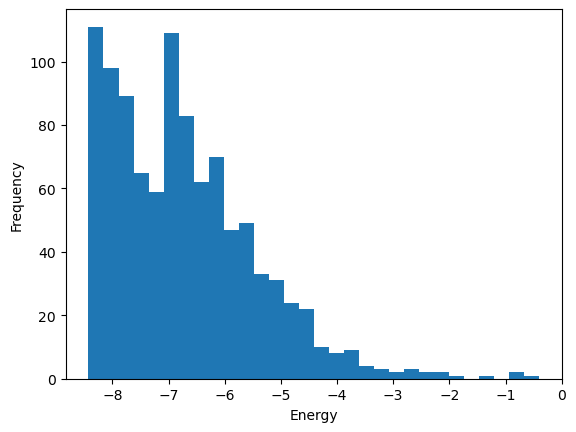

In [16]:
plt.hist(E(training_set[:,0],training_set[:,1]),bins=30)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

In this way, we can clearly see the presence of the two distinct energy wells. 

## Hyperparameter optimization

The effect of changing the hyperparameters will be checked here. The hyperparameters defined are:

-The ratio between the energy and entropy contribution in the kl loss.

-The ratio Hamiltonian/entropy in the ml loss

-Deepness of the network (layers in s and t networks as well as amount of masks)

-"Width" of the network (amount of nodes per hidden layer, which are only incorporated in the s and t networks)

-Sample size -- amount of samples used to perform the training by example as well as the amount of samples used to perform the training by energy.

-iterations (number of steps in the training process)


In [17]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005]]
ratios_kl_loss=[[1,1],[1,2],[1,3],[1,4],[1,5],[5,1],[4,1],[3,1],[2,1]]
width_network=[256,512]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100]]
# learning_rates=[[0.001,0.0005]]
# ratios_kl_loss=[[1,1]]
# width_network=[256]
# sample_size=[[1000,1000]]
# iterations=[[100,100]]

In [18]:
print(f"{ratios_kl_loss[0]}")

[1, 1]


In [19]:
def define_variables(hid_lay=256, l_hid=3, iter_ex=100, iter_en=100, sample_size_ex=1000, sample_size_en=1000, lr_ex=0.001, lr_en=0.0005):
    
    nodes_per_hidden_layer=hid_lay
    number_of_hidden_layers=l_hid
    iterations_train_example=iter_ex
    iterations_train_energy=iter_en
    samples_for_training_example=sample_size_ex
    samples_for_training_energy=sample_size_en
    learning_rate_for_training_example=lr_ex
    learning_rate_for_training_energy=lr_en

    return nodes_per_hidden_layer, number_of_hidden_layers, iterations_train_example, iterations_train_energy, samples_for_training_example, samples_for_training_energy \
                ,learning_rate_for_training_example, learning_rate_for_training_energy




In [20]:
# Define our model (the triple well potential)
triplewell = TripleWell()
temperature = 1.0 # doesn't do anything

learning_rates=[[0.001,0.001],[0.001,0.0005],[0.001,0.0001],[0.01,0.0005]]
width_network=[128,256,512]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,25],[100,50],[100,75],[200,50]]
# learning_rates=[[0.001,0.0005]]
# ratios_kl_loss=[[1,1]]
# width_network=[256]
# sample_size=[[1000,1000]]
# iterations=[[100,100]]

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                n_hidden, l_hidden, iter1, iter2, sample_size1, sample_size2, lr1, lr2 = define_variables(hid_lay=width, iter_ex=iter[0], iter_en=iter[1], sample_size_ex=size[0], sample_size_en=size[1], lr_ex=lr[0], lr_en=lr[1])

                # Define the network architecture
                nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
                nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
                masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
                prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
                model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

                x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], int(0.6*sample_size1)).T
                x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], int(0.4*sample_size1)).T

                coords_state_a = np.stack((x_state_a,y_state_a),axis=1)
                coords_state_b = np.stack((x_state_b,y_state_b),axis=1)
                training_set = np.concatenate((coords_state_a,coords_state_b))

                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
                training_set = training_set.astype('float32')
                trainloader = data.DataLoader(dataset=training_set, batch_size=1000)

                losses = [] # for visualizing loss as a function of iteration number rather than epoch number
                t = 0 # iteration count

                while t < iter1:
                    for batch in trainloader:  

                        # Custom ML loss function
                        loss = model.loss_ml(batch) 
                        losses.append(loss.item()) # save values for plotting later 

                        # Training
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True)
                        optimizer.step()

                        t = t + 1 # iteration count

                # # Visualize loss
                # fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
                # fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                #                     mode='lines',
                #                     name='lines'))

                # fig.update_layout(yaxis_title='Loss',
                #                 xaxis_title='Iteration #')


                z, x = model.sample(sample_size2)

                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
                training_set_2 = (z.astype('float32'))
                trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=25000)

                t = iter1

                while t < iter1 + iter2:
                    for batch_z in trainloader_2:  
                        # KL loss function
                        loss = model.loss_kl(batch_z)
                        losses.append(loss.item()) # save values for plotting later 

                        # Training on KL loss
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True)
                        optimizer.step()

                        t = t + 1 # iteration count

                z1, x1 = model.sample(500000)

                print(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv"+"is trained")

                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",coords_state_a,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",coords_state_b,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",z,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",x,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",z1,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",x1,delimiter=",")

                print(f"and the data written to the files"+"\n")

/Users/toon/anaconda3/lib/python3.10/site-packages/torch/distributions/distribution.py:166: UserWarning:

sample_n will be deprecated. Use .sample((n,)) instead



lr=0.001_0.001_width=128_size=1000_1000_iter=100_25_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.001_width=128_size=1000_1000_iter=100_50_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.001_width=128_size=1000_1000_iter=100_75_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.001_width=128_size=1000_1000_iter=200_50_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.0005_width=128_size=1000_1000_iter=100_25_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.0005_width=128_size=1000_1000_iter=100_50_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.0005_width=128_size=1000_1000_iter=100_75_x_after_training_energy.csvis trained
and the data written to the files

lr=0.001_0.0005_width=128_size=1000_1000_iter=200_50_x_after_training_energy.csvis trained
and the data written to the fil

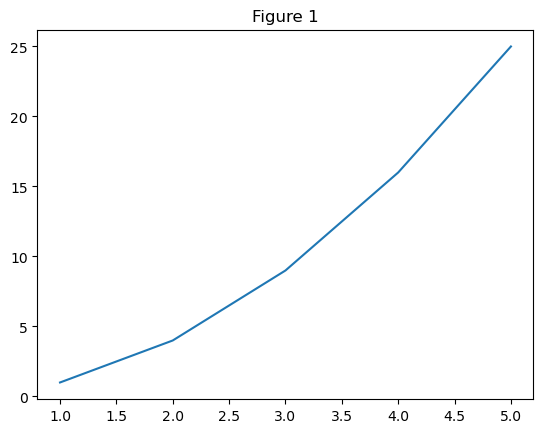

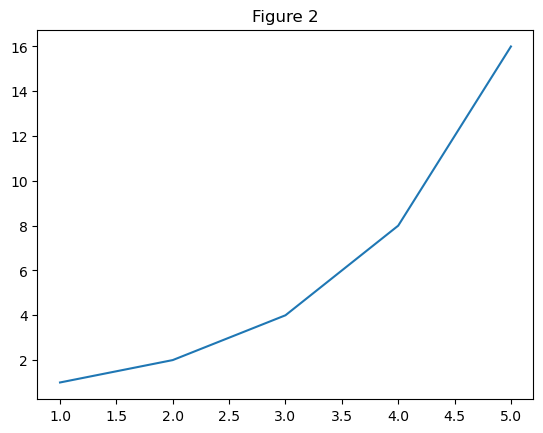

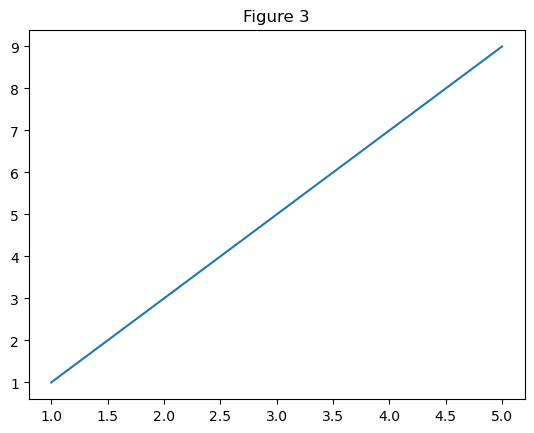

In [100]:
# Create some sample data
x = [1, 2, 3, 4, 5]
y1 = [1, 4, 9, 16, 25]
y2 = [1, 2, 4, 8, 16]
y3 = [1, 3, 5, 7, 9]

# Create the first figure
fig1 = plt.figure()
plt.plot(x, y1)
plt.title('Figure 1')

# Create the second figure
fig2 = plt.figure()
plt.plot(x, y2)
plt.title('Figure 2')

# Create the third figure
fig3 = plt.figure()
plt.plot(x, y3)
plt.title('Figure 3')

# Display the figures
plt.show()

Text(0.5, 1.0, '$X = g(z)$')

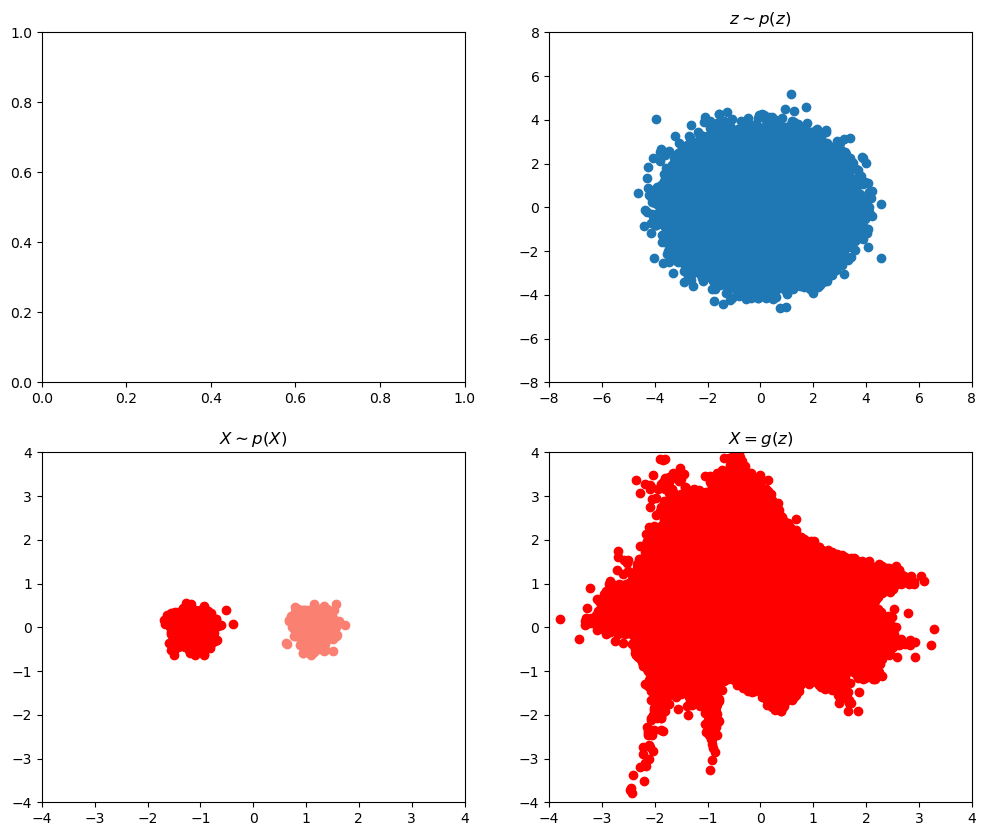

In [85]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(222)
plt.scatter(z1[:, 0], z1[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

## Boltzmann generator training
We would now like to infer the energy landscape through direct sampling of a learned latent space description of this sytem. We achieve this by training a Boltzmann generator on the given input data. We begin by defining our network architecture, using the specifications given on pg. 4 of the SI of Noe et al.: 

In [81]:
n_hidden = 256  # number of nodes in each hidden layer
temperature = 1.0 # doesn't do anything
l_hidden = 3   # number of hidden layers 

There the training schedule is also specified. Let "1" in the following denote the first set of iterations (where only the ML loss is used) while "2" refers to the second second of iterations (where both the ML and KL loss is utilized): 

In [82]:
iter1 = 100
iter2 = 200

batch_size1 = 1000 # less than 1000 does not seem to converge 
batch_size2 = 50000

lr1 = 0.001 # could not get monotonic decrease of loss with largest learning rates when using standard gradient descent. 
lr2 = 0.0001

We can now create the Boltzmann generator network: 

In [83]:
# Parameter Debugging
n_hidden = 256

# Define our model (the triple well potential)
triplewell = TripleWell()

# Define the network architecture
nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

### Training by example
Time to train the model. We first "train by example" by computing only the ML loss. This loss essentially maximizes the likelihood of our input configurations in the latent space Gaussian distribution. 

In contrast, the KL loss promotes sampling of low-energy states; it also includes an entropic contribution to penalize repeated sampling of the same stable state. 

In [84]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
training_set = training_set.astype('float32')
trainloader = data.DataLoader(dataset=training_set, batch_size=batch_size1)

losses = [] # for visualizing loss as a function of iteration number rather than epoch number
t = 0 # iteration count

while t < iter1:
    for batch in trainloader:  

        # Custom ML loss function
        loss = model.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

iter 25: loss = -0.650
iter 50: loss = -1.341
iter 75: loss = -1.413
iter 100: loss = -1.435


It appears from the above plot of the ML loss that the model has been succesfully trained. Let's confirm this by now sampling from the learned latent space distribution and trying to then infer the energy landscape in real space from these samples. 

/Users/toon/anaconda3/lib/python3.10/site-packages/torch/distributions/distribution.py:166: UserWarning:

sample_n will be deprecated. Use .sample((n,)) instead



Text(0.5, 1.0, '$X = g(z)$')

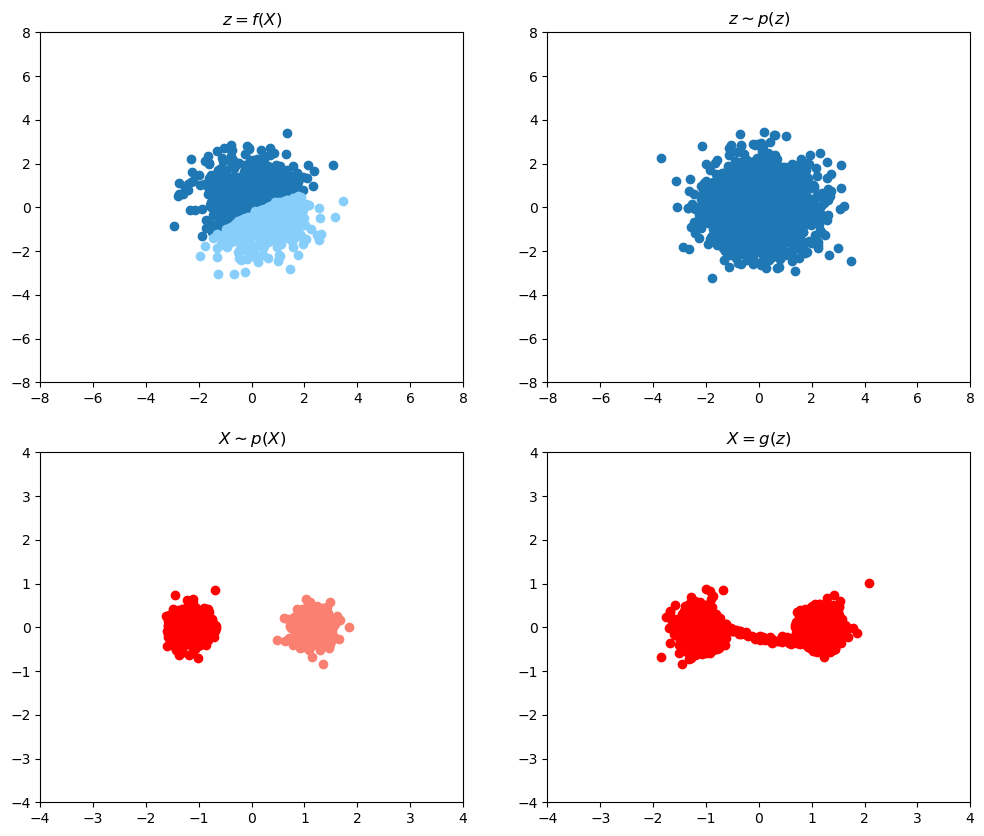

In [85]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(2000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

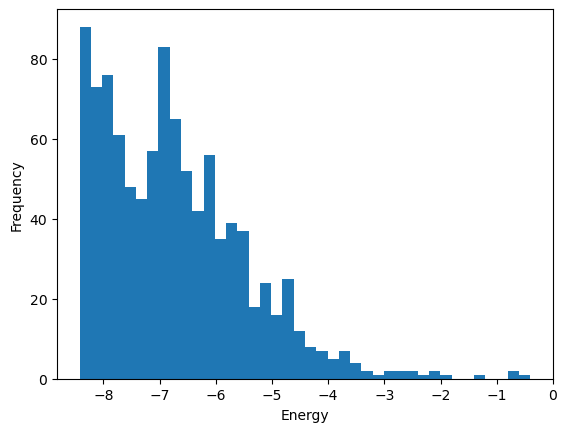

In [86]:
plt.hist(model.energies,bins=40)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

### Training by energy
We will now train with the KL loss to teach the network to focus on both low energy states. 

In [87]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
training_set_2 = (z.astype('float32'))
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)

t = iter1

while t < iter1 + iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = model.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count

        if 

        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss', xaxis_title='Iteration #')

iter 125: loss = -4.206
iter 150: loss = -4.230
iter 175: loss = -4.242
iter 200: loss = -4.249
iter 225: loss = -4.254
iter 250: loss = -4.257
iter 275: loss = -4.260
iter 300: loss = -4.263


NameError: name 'model' is not defined

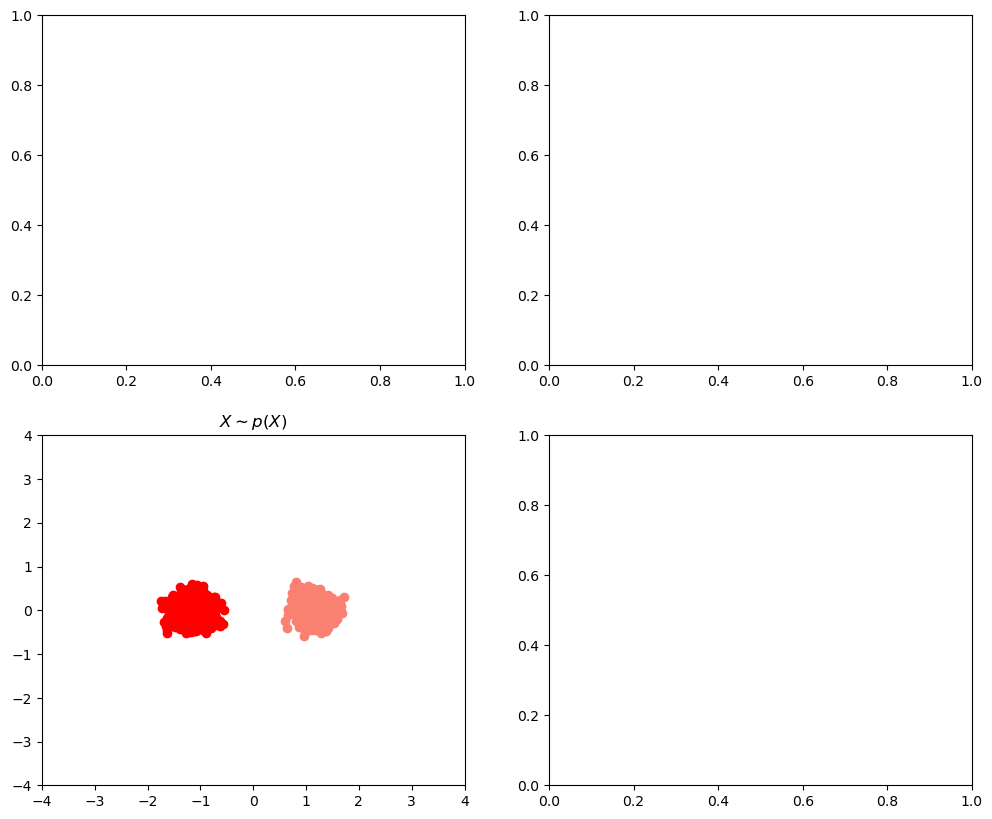

In [24]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z1, x1 = model.sample(500000)
plt.subplot(222)
plt.scatter(z1[:, 0], z1[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

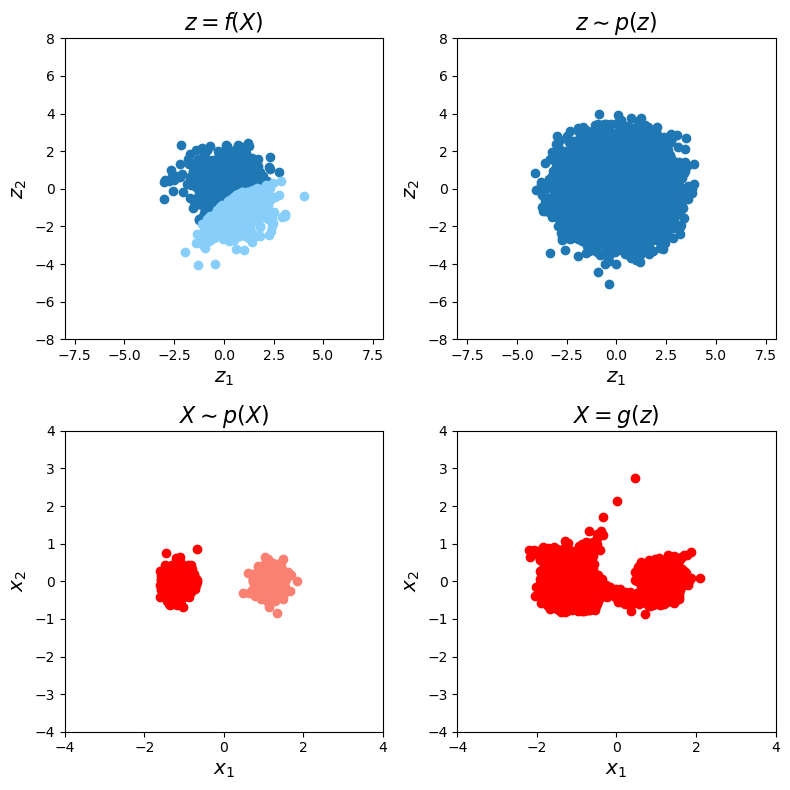

In [36]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

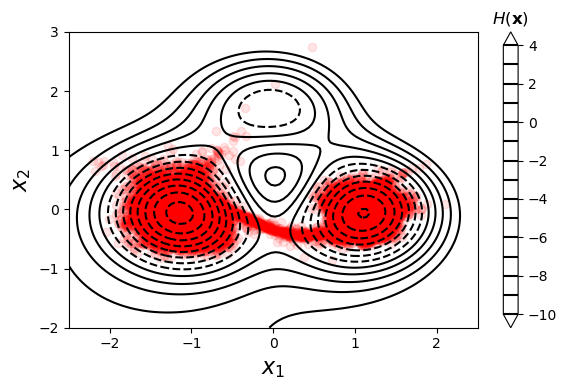

In [35]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',colors='k');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)
plt.scatter(x[:, 0], x[:, 1], c='r', alpha=0.1) 
plt.xlim([-2.5,2.5])
plt.ylim([-2,3])

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

For the purposes of the report, we will visualize the data in a different order: 

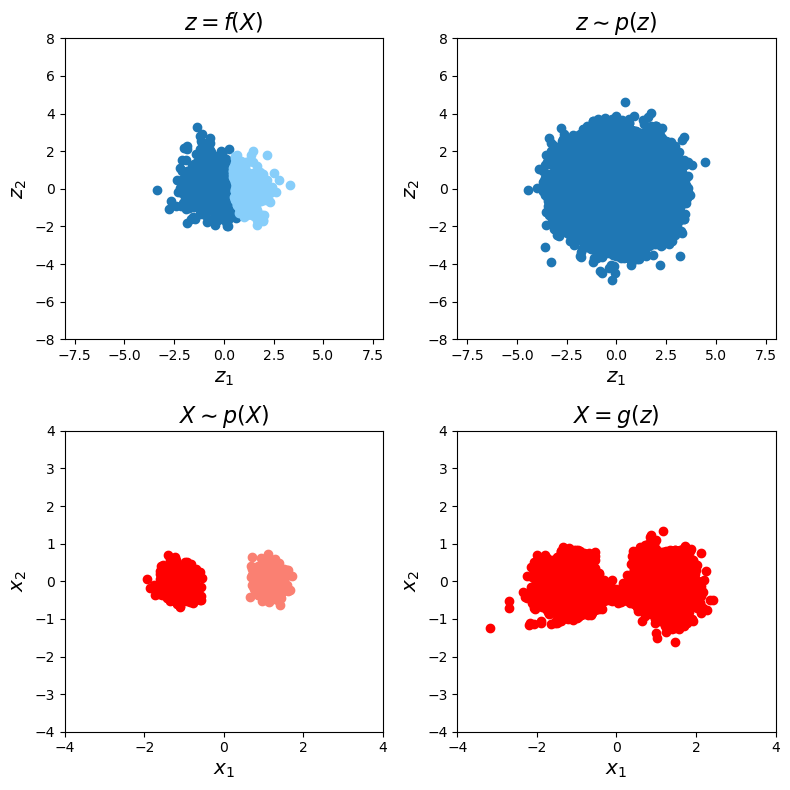

In [46]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(100000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

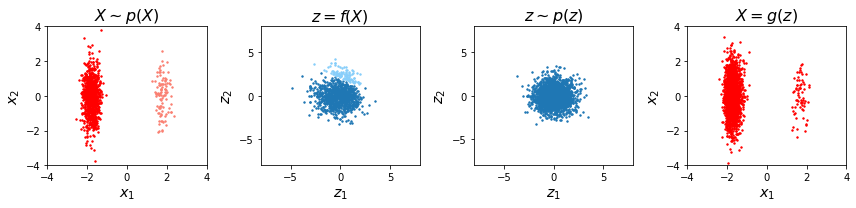

In [22]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(1,4, figsize = (12,3)) # width x height in inches
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(141)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r',s = my_s)
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon',s = my_s)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
plt.subplot(142)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue',s = my_s)
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue',s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(143)
plt.scatter(z[:, 0], z[:, 1],s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
plt.subplot(144)
plt.scatter(x[:, 0], x[:, 1], c='r',s = my_s) # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results.png", dpi=600, transparent=False)

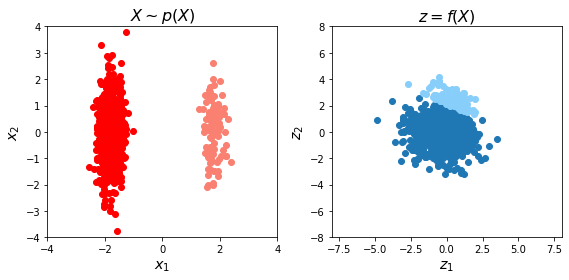

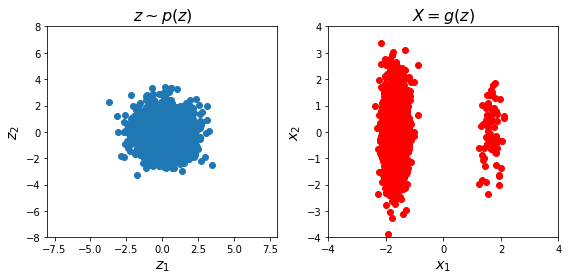

In [29]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 1, figsize = (8,4))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(121)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(122)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_top.png", dpi=600, transparent=False)
fig, axes = plt.subplots(2, 1, figsize = (8,4))

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(121)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(122)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_bottom.png", dpi=600, transparent=False)

### Free Energy
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by: 

$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

In [24]:
z_fe, x_fe = model.sample(500000)

KeyboardInterrupt: 

In [ ]:
x1 = x_fe[:,0]
x2 = x_fe[:,1]

counts, bins = np.histogram(x1, bins = 200)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)

In [ ]:
# Visualize the results
plt.scatter(anchors, fn) 

plt.xlabel("$x_1$")
plt.ylabel(r"$(f - f_0) / k_B T$")

plt.show()

For the simple double well potential, we can also calculate this free energy analytically. The partition function $Z$ is given by: 
$$ \ln Z(x_1) = \sqrt{2\pi}\big( x_1^4 - 6*x_1^2 + x_1 \big)$$
from which we can calculate the free energy via $f=-k_B T \ln Z$

In [ ]:
fig, axes = plt.subplots(figsize = (6,4))
x1 = np.linspace(-2.5,2.5,1000)
logz = (x1**4 - 6*x1**2 + x1) + 11

plt.plot(x1,logz)
plt.scatter(anchors, fn,color='orange') 

plt.xlabel("$x_1$", fontsize = my_font_size)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize = my_font_size)

plt.tight_layout()
plt.savefig("images/double_well_fe.png", dpi=600, transparent=False)
plt.show()

## Notes
- List of Plotly colors: https://community.plot.ly/t/plotly-colours-list/11730/3